# Homework 3: Optimization

## Optimization via Gradient Descent

* $x_0=(0,\ldots,0)^T$
* $k_{max}=100$
* choose values for `tolf` and `tolx`

- [x] Write a script that implement the GD method
- [x] Add backtracking algorithm to the GD method
- [x] Write all functions and their gradients
- [x] Test for each function the gd method with and without the backtracking (trying different values for the step_size)
- [x] Plot the error vector that contains $||∇f(x_k)||_2$, to check that it goes to zero.
- [x] Compare the convergence speed (in terms of the number of iterations $k$)
- [x] Plot the error $||x_k − x^*||_2$ varying $k$ when the true x∗ is available.
- [x] Only for the non-convex function defined in 5, plot it in the interval [−3, 3] and test the convergence point of GD with different values of x0 and different step-sizes. Observe when the convergence point is the global minimum and when it stops on a local minimum or maximum.
- [x] Hard (optional): For the functions 1 and 2, plot the contour around the minimum and the path defined by the iterations (following the example seen during the lesson). See `plt.contour` to do that.

In [538]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt

def backtracking(f, grad_x, x, c=0.25, t=0.5):
    a = 1
    
    while f(x - a * grad_x) > f(x) - c * a * norm(grad_x, 2) ** 2:
        a *= t
        
        if a < 1e-5:
            break
    return a

def gd(f, grad_f, x0, a = None, kmax = 100, tolf = 1e-6, tolx = 1e-6):
    """
    Parameters
    ----------
    f: the function f(x) we want to optimize. It is supposed to be a Python function, not an array.
    grad_f: the gradient of f(x). It is supposed to be a Python function, not an array.
    x0: an n-dimensional array which represents the initial iterate.
    kmax: an integer. The maximum possible number of iterations (to avoid infinite loops)
    tolf: small float. The relative tolerance of the algorithm. Convergence happens if ||grad_f(x_k)||_2 < tolf ||grad_f(x_0)||_2
    tolx: small float. The tolerance in the input domain. Convergence happens if ||x_{k} - x_{k-1}||_2 < tolx. Pay attention to to the first iterate.
               
    Returns
    ----------
    x: an array that contains the value of x_k FOR EACH iterate x_k (not only the latter).
    k: an integer. The number of iteration needed to converge. k < kmax.
    f_val: an array that contains the value of f(x_k) FOR EACH iterate x_k.
    grads: an array that contains the value of grad_f(x_k) FOR EACH iterate x_k.
    err: an array the contains the value of ||grad_f(x_k)||_2 FOR EACH iterate x_k.
    """
    k = 0
    x = [np.array(x0)]
    fval = [f(x0)]
    grads = [grad_f(x[0])]
    err = [norm(grads[0], 2)]
    
    condition = True
    while condition:
        a = a if a is not None else backtracking(f, grads[-1],  x[-1])
        x.append(x[-1] - a * grads[-1])
        fval.append(x[-1])
        grads.append(grad_f(x[-1]))
        err.append(norm(grads[-1], 2))

        condition1 = err[-1] >= tolf * err[0]
        condition2 = norm(x[-1] - x[-2], 2) >= tolx
        condition3 = k < kmax
        condition = condition1 and condition2 and condition3

        if not condition1:
            print(f"Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration {k+1}")
        elif not condition2:
            print(f"Stopped: ||x_k - x_k-1||_2 < tolx (tolx reached) at iteration {k+1}")
        elif not condition3:
            print(f"Stopped: k >= kmax (maximum number of iterations reached)")

        k += 1
    return x, k, fval, grads, err 

In [539]:
# R2->R x*=[3,1]
def effe1(x):
    return (x[0] - 3)**2 + (x[1] - 1)**2
def grad_effe1(x):
    return np.array([2 * (x[0] - 3), 2 * (x[1] - 1)])

# R2->R x*=[1,2]
def effe2(x):
    return 10*(x[0]-1)**2+(x[1]-2)**2
def grad_effe2(x):
    return np.array([20 * (x[0] - 1), 2 * (x[1] - 2)])

def generate_AB(n):
    x_true = np.ones(n)
    A = np.vander(np.linspace(0, 1, n))
    b = A @ x_true
    return A, b

# Rn->R x*=[1,...,1]
def effe3(x):
    A, b = generate_AB(len(x))
    return 0.5 * norm(A @ x - b, 2)**2
def grad_effe3(x):
    A, b = generate_AB(len(x))
    return A.T @ (A @ x -  b)

# R2->R x*=[1,...,1]
def generate_effe4(lmb):
    def effe4(x):
        A, b = generate_AB(len(x))
        return 0.5 * norm(A @ x - b, 2)**2 + 0.5 * lmb * norm(x, 2)**2
    def grad_effe4(x):
        A, b = generate_AB(len(x))
        return A.T @ (A @ x -  b) + lmb * x
    
    return effe4, grad_effe4

# R->R
def effe5(x):
    return x[0]**4 + x[0]**3 - 2 * x[0]**2 - 2 * x[0]
def grad_effe5(x):
    return np.array([4 * x[0]**3 + 3 * x[0]**2 - 4 * x[0] -2])

In [540]:
def plot_3d_surface(f, x1_range, x2_range, f_string):
    x1 = np.linspace(*x1_range, 100)
    x2 = np.linspace(*x2_range, 100)
    x1, x2 = np.meshgrid(x1, x2)
    z = f([x1, x2])
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x1, x2, z, cmap='viridis')

    ax.set_title(f"Surface Plot of f={f_string}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x)')
    
    plt.show()

def plot_grad_error(err_list, labels, f_string):
    for err, label in zip(err_list, labels):
        iterations = np.arange(1, len(err) + 1)
        plt.plot(iterations, err, marker='o', linestyle='-', label=label)
    
    plt.title(f"Convergence of gradient descent for f={f_string}")
    plt.xlabel('Iterations')
    plt.ylabel('Error $||∇f(x_k)||_2 $')
    plt.yscale('log')

    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

def plot_difference_error(x, xstar, f_string):
    iterations = np.arange(1, len(x) + 1)
    solution_err = [norm(np.array(x_k) - np.array(xstar), 2) for x_k in x]
    plt.plot(iterations, solution_err, marker='+', linestyle='-')

    plt.title(f"Approximation error for f={f_string}")
    plt.xlabel('Iterations')
    plt.ylabel('Error $||x_k-x*||_2 $')
    plt.yscale('log')

    plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

    plt.grid(True, alpha=0.4)
    plt.show()

def plot_gd_path1D(f, xstar, path, x1_range, f_string):
    x = np.linspace(*x1_range, 100)
    plt.plot(x, f([x]))
    plt.plot([xk[0] for xk in path], [f(xk) for xk in path], color='blue', marker='o', linestyle='-', label='gd path')
    plt.plot(xstar[0], f(xstar), marker='*', color='red', label='$x*$', zorder=2)
    plt.plot(path[0], f(path[0]), marker='o', color='green', label='$x_0$', zorder=2)

    plt.title(f"Gradient descent path for f={f_string}")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.xlabel('x')
    plt.ylabel('f(x)')
    
    plt.legend()
    plt.show()

def plot_gd_path2D(f, xstar, path, x1_range, x2_range, f_string):
    x1 = np.linspace(*x1_range, 100)
    x2 = np.linspace(*x2_range, 100)
    X, Y = np.meshgrid(x1, x2)
    Z = f([X, Y])
    
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot([xk[0] for xk in path], [xk[1] for xk in path], color='blue', lw=2, label='gd path')
    plt.plot(*xstar, marker='*', color='red', label='$x*$', zorder=2)
    plt.plot(path[0][0], path[0][1], marker='o', color='green', label='$x_0$', zorder=2)
    
    plt.title(f"Gradient descent path for f={f_string}")
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.legend()
    plt.show()

def test_gd(f, grad_f, x0, xstar, f_string, a_list=[0.01, 0.1, 0.25, 0.5, None], x1_range=None, x2_range=None):
    all_errors = []
    labels = []
    
    for a_k in a_list:
        x, _, fval, grads, err = gd(f, grad_f, x0, a_k)
        all_errors.append(err)
        labels.append(f'$\\alpha$ = {a_k}' if a_k is not None else 'backtracking $\\alpha$')
        new_string = f"{f_string} with $\\alpha=$ {a_k}"
        if x1_range is not None and x2_range is None:
            plot_gd_path1D(f, xstar, x, x1_range, new_string)
        elif x1_range is not None and x2_range is not None:
            plot_gd_path2D(f, xstar, x, x1_range, x2_range, new_string)
        if xstar is not None:
            plot_difference_error(x, xstar, new_string)
    
    plot_grad_error(all_errors, labels, f_string)

### Function 1 tests

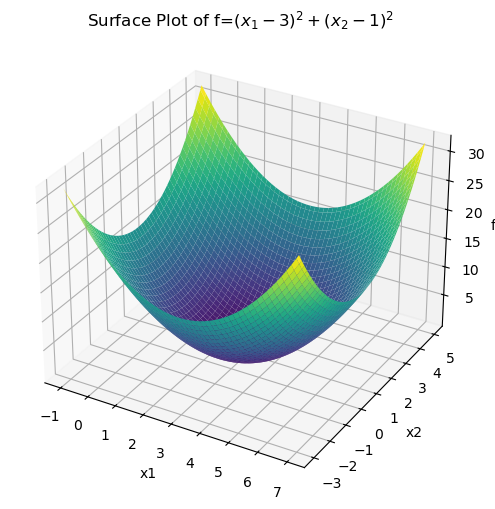

Stopped: k >= kmax (maximum number of iterations reached)


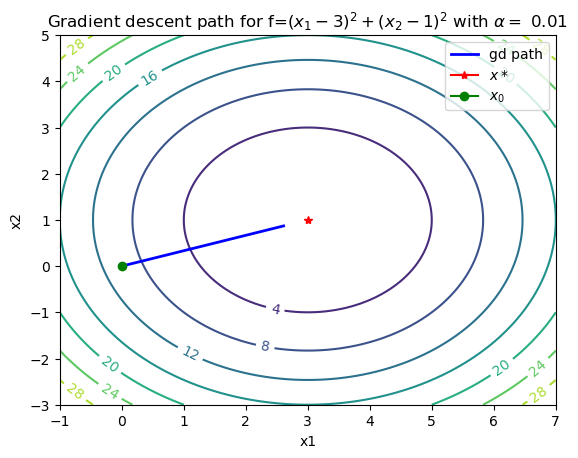

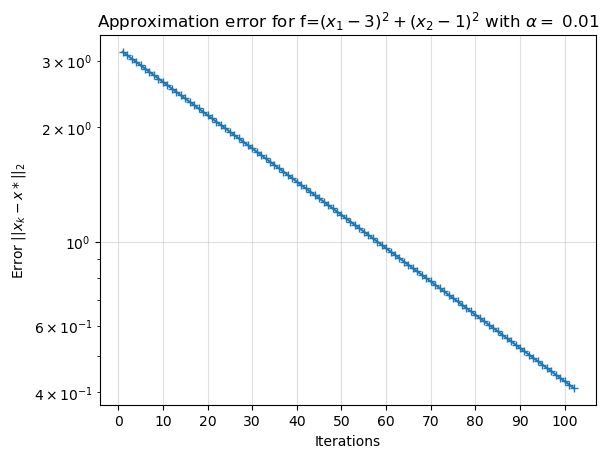

Stopped: ||x_k - x_k-1||_2 < tolx (tolx reached) at iteration 61


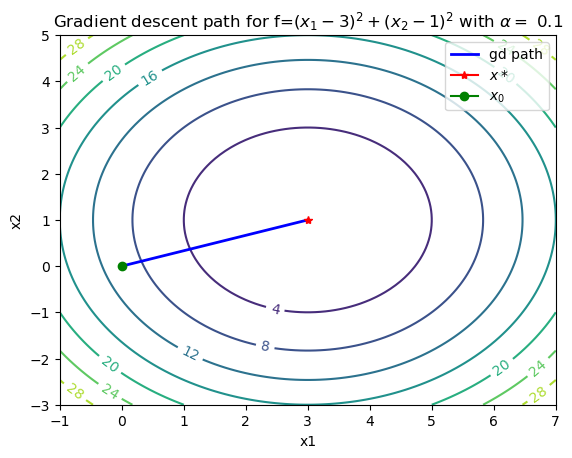

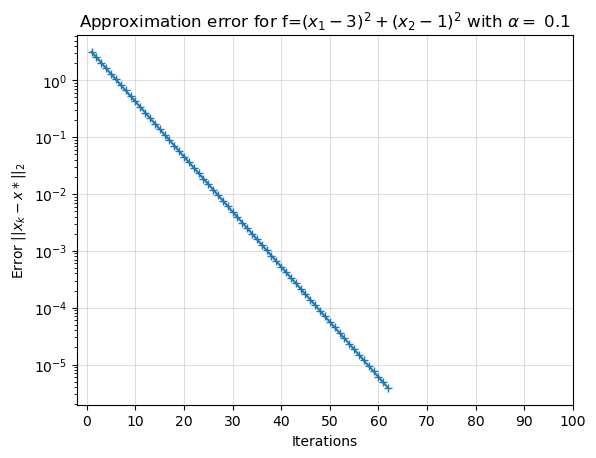

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 20


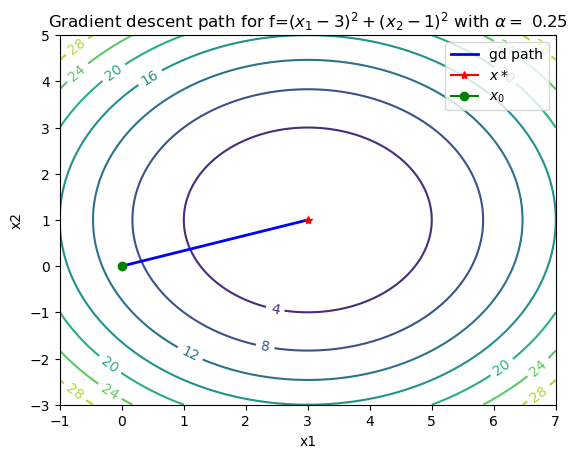

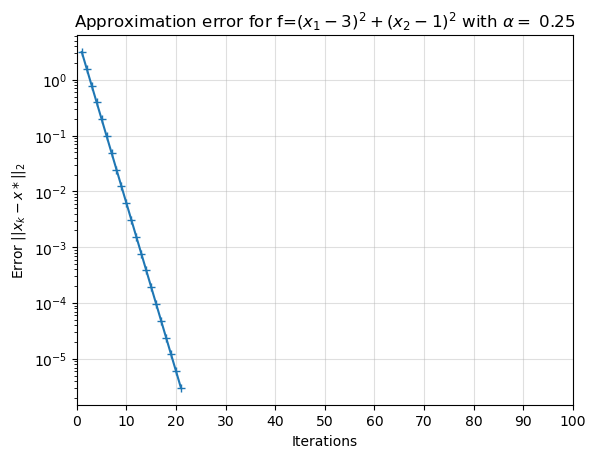

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 1


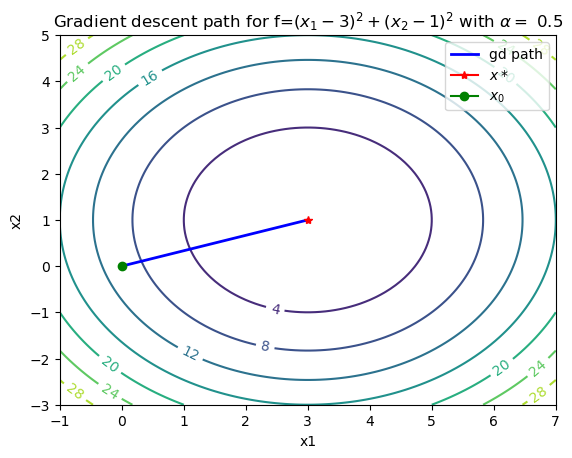

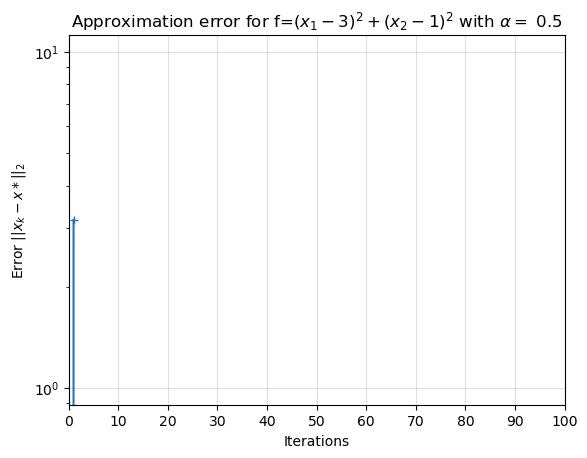

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 1


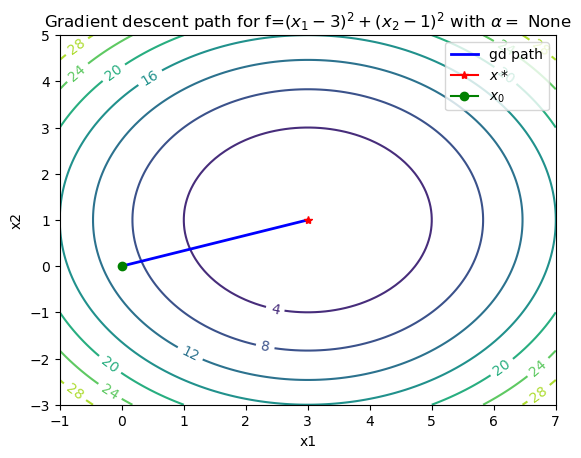

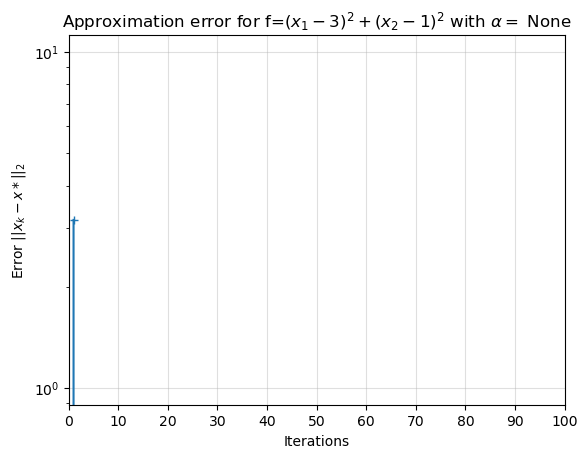

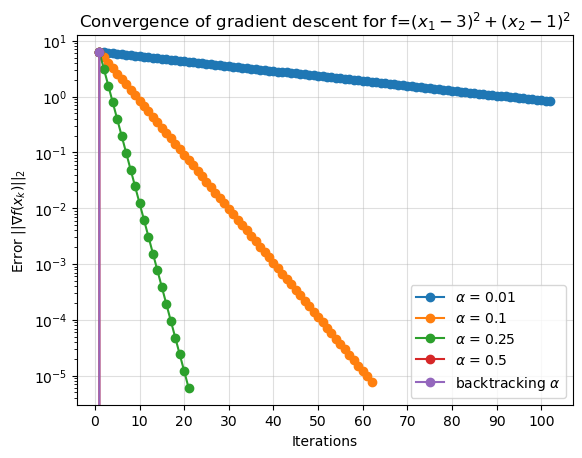

In [541]:
effe1_x1_range = (-1, 7)
effe1_x2_range = (-3, 5)
effe1_string = "$(x_1-3)^2+(x_2-1)^2$"
effe1_xstar = (3,1)
effe1_x0 = (0,0)

plot_3d_surface(effe1, effe1_x1_range, effe1_x2_range, effe1_string)
test_gd(effe1, grad_effe1, effe1_x0, effe1_xstar, effe1_string, x1_range=effe1_x1_range, x2_range=effe1_x2_range)

Choosing a very small alpha increases iteration count, leading to slow convergence, while a large alpha may cause divergence. Optimal convergence is achieved with a moderate alpha like 0.5 or when using backtracking

### Function 2 tests

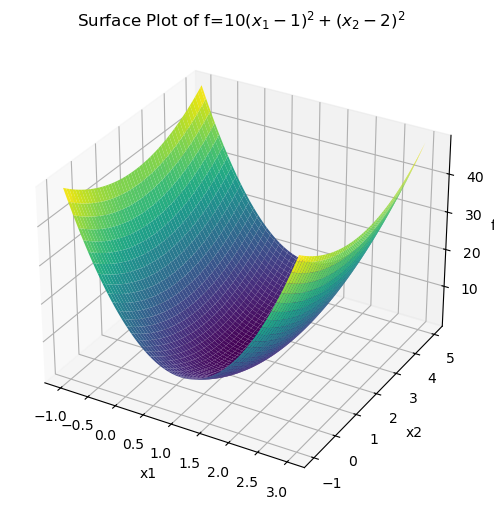

Stopped: k >= kmax (maximum number of iterations reached)


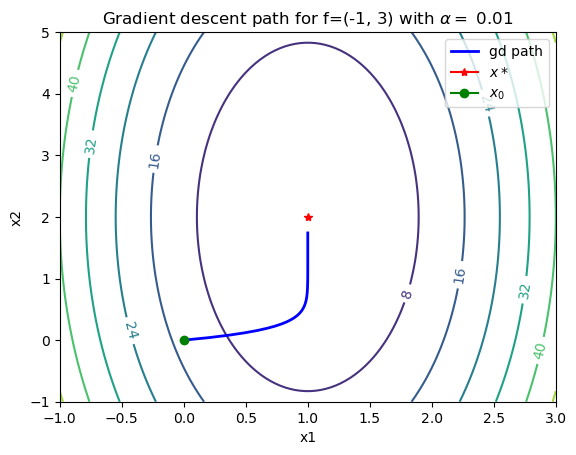

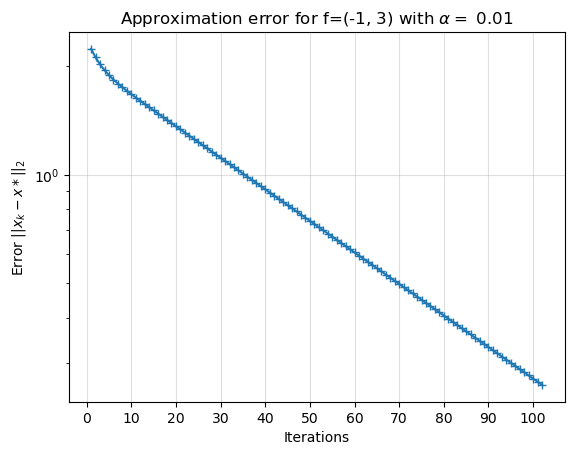

Stopped: k >= kmax (maximum number of iterations reached)


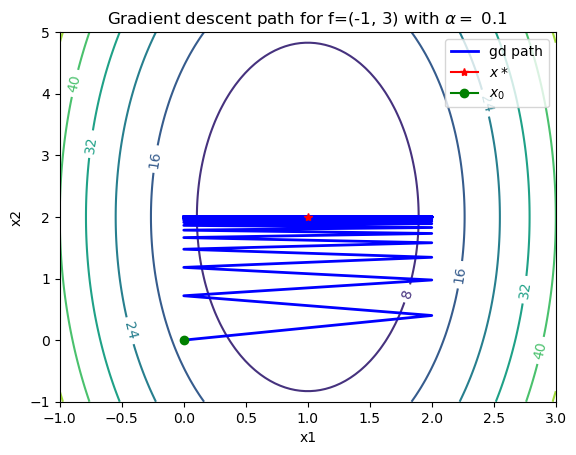

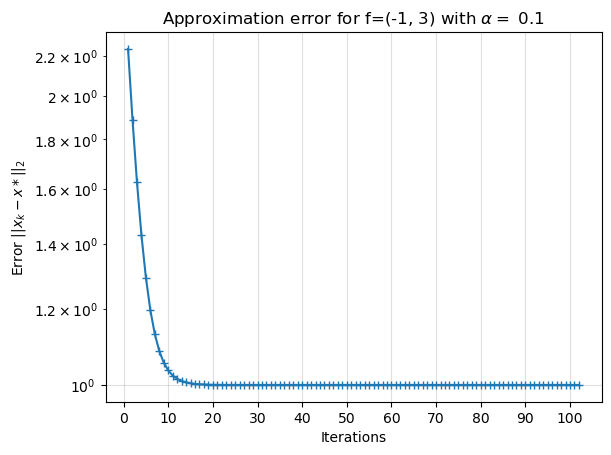

Stopped: k >= kmax (maximum number of iterations reached)


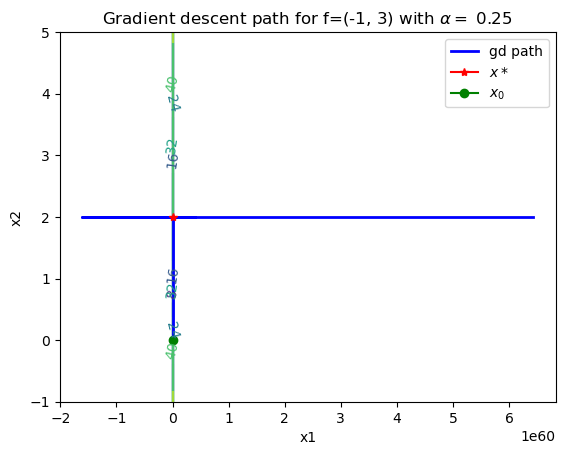

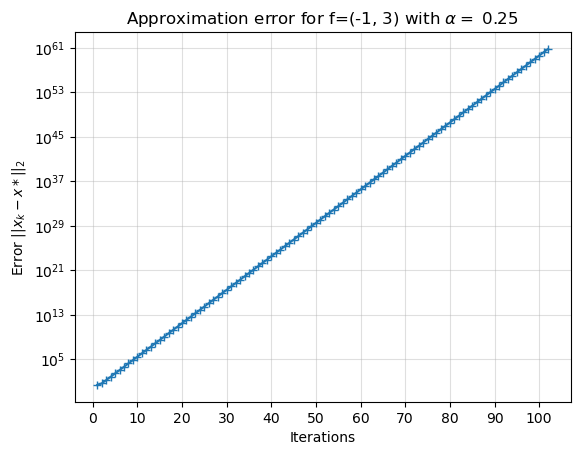

Stopped: k >= kmax (maximum number of iterations reached)


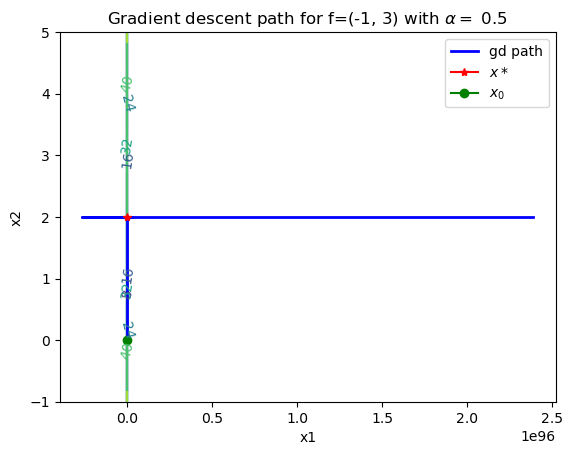

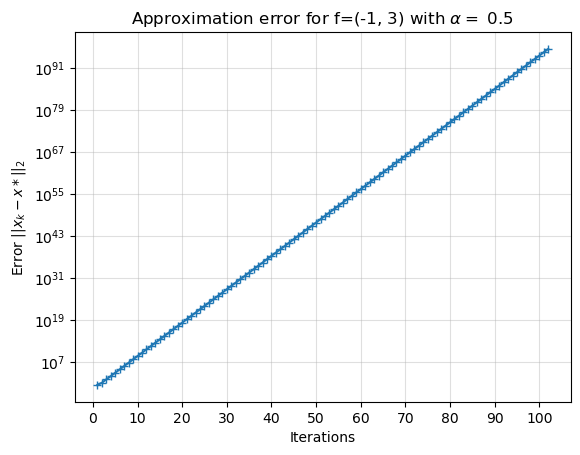

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 92


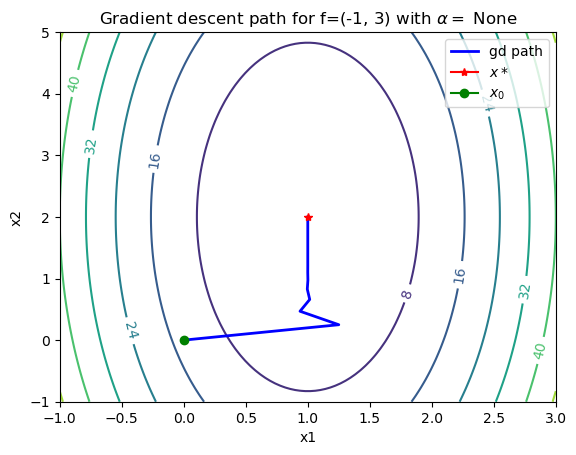

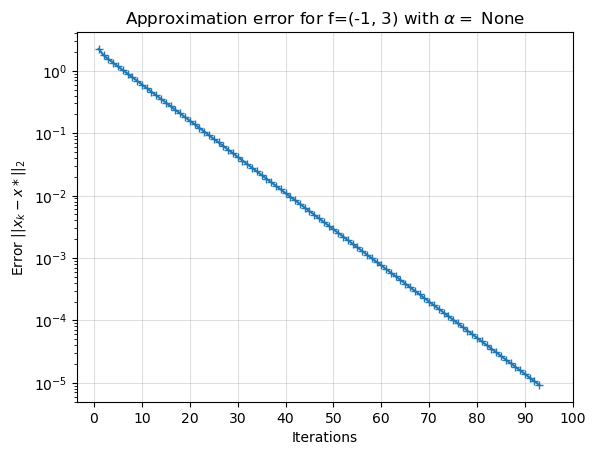

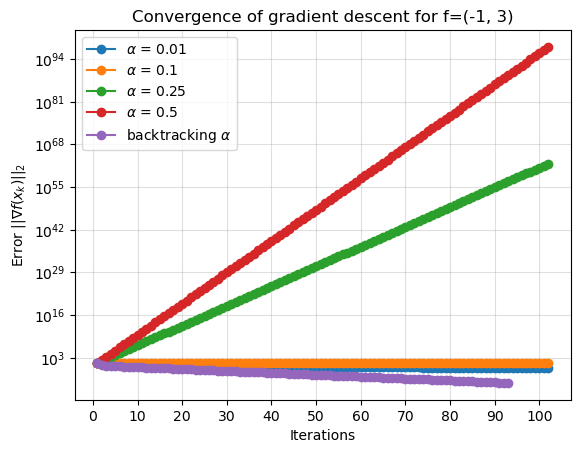

In [542]:
effe2_x1_range=(-1, 3)
effe2_x2_range=(-1, 5)
effe2_string = "$10(x_1-1)^2+(x_2-2)^2$"
effe2_xstar = (1,2)
effe2_x0 = (0,0)

plot_3d_surface(effe2, effe2_x1_range, effe2_x2_range, effe2_string)
test_gd(effe2, grad_effe2, effe2_x0, effe2_xstar, effe2_x1_range, x1_range=effe2_x1_range, x2_range=effe2_x2_range)

The convergence is only achieved by obtaining $\alpha$ using backtracking. With a very small $\alpha$, it takes too much time $(>k_{max})$ without reaching the minimum. In contrast, if we use a larger $\alpha$, it starts bouncing within the "canyon", never reaching the minimum, or worse, it begins to diverge.

### Function 3 tests

Stopped: k >= kmax (maximum number of iterations reached)


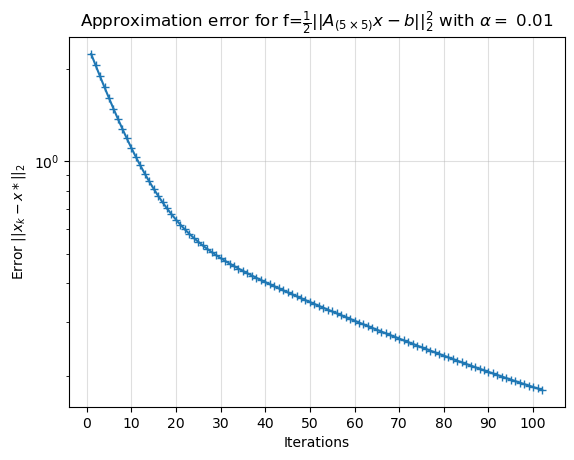

Stopped: k >= kmax (maximum number of iterations reached)


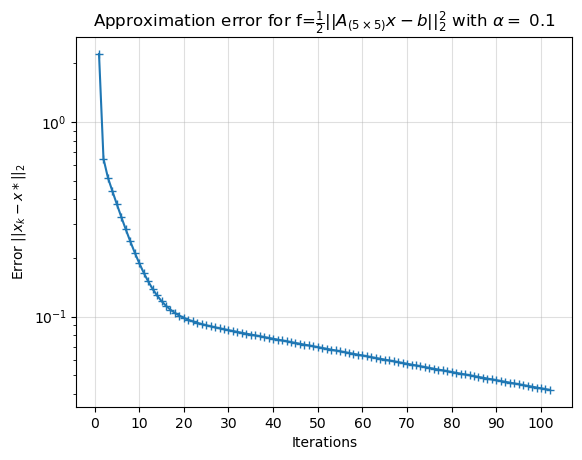

Stopped: k >= kmax (maximum number of iterations reached)


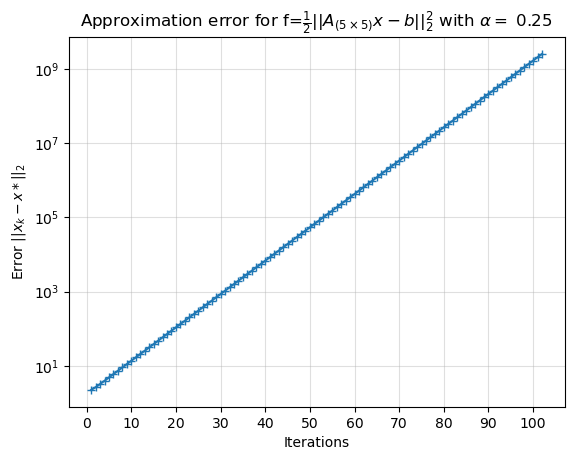

Stopped: k >= kmax (maximum number of iterations reached)


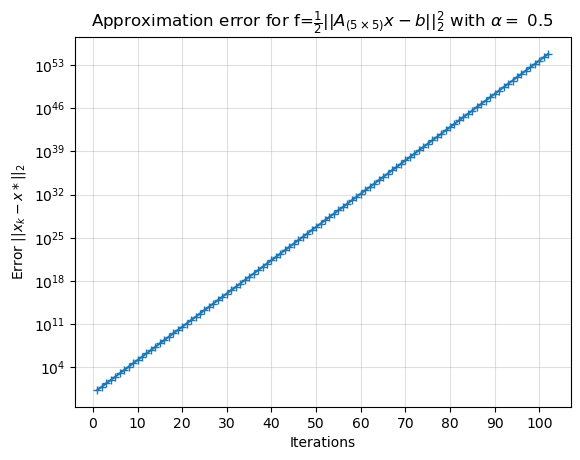

Stopped: k >= kmax (maximum number of iterations reached)


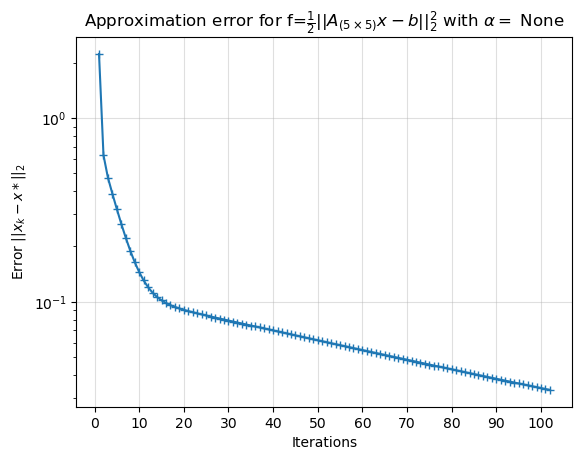

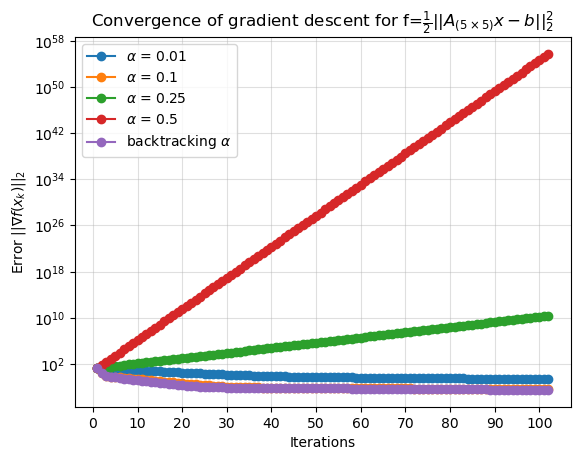

Stopped: k >= kmax (maximum number of iterations reached)


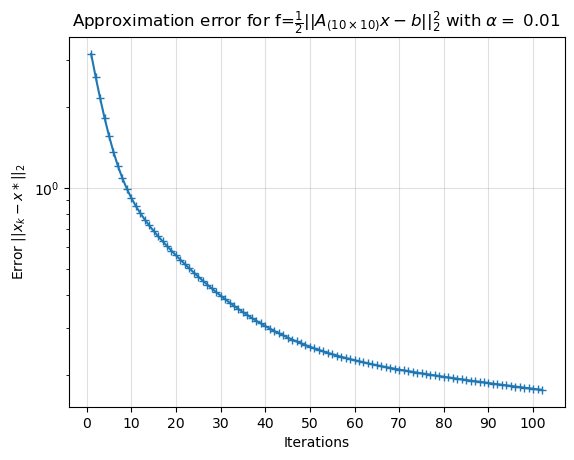

Stopped: k >= kmax (maximum number of iterations reached)


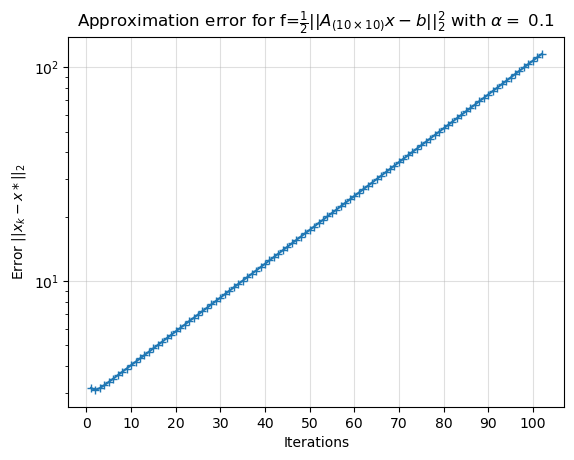

Stopped: k >= kmax (maximum number of iterations reached)


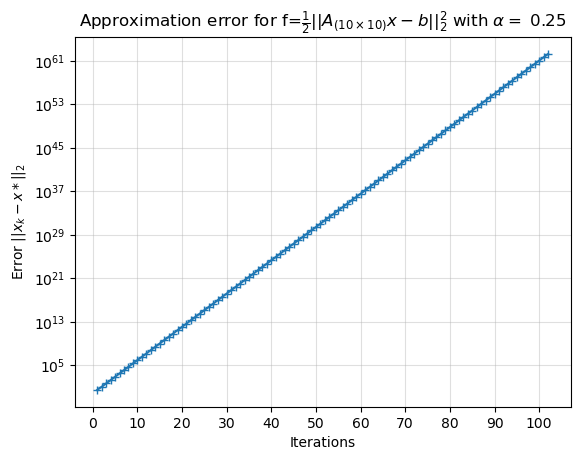

Stopped: k >= kmax (maximum number of iterations reached)


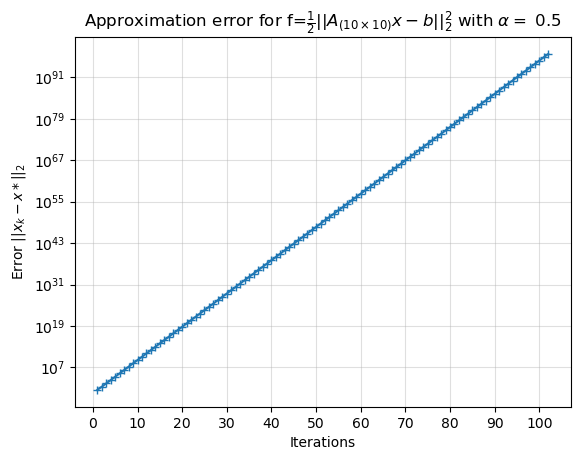

Stopped: k >= kmax (maximum number of iterations reached)


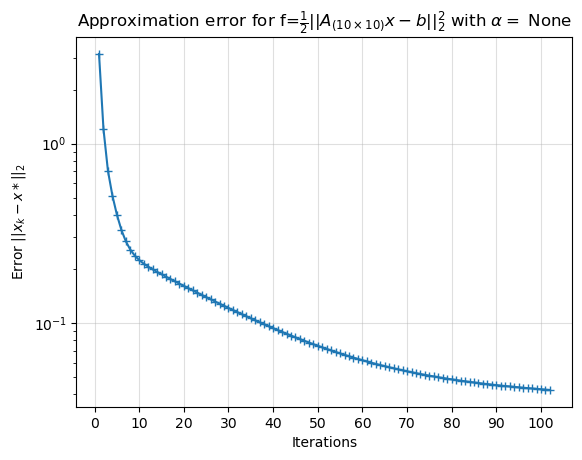

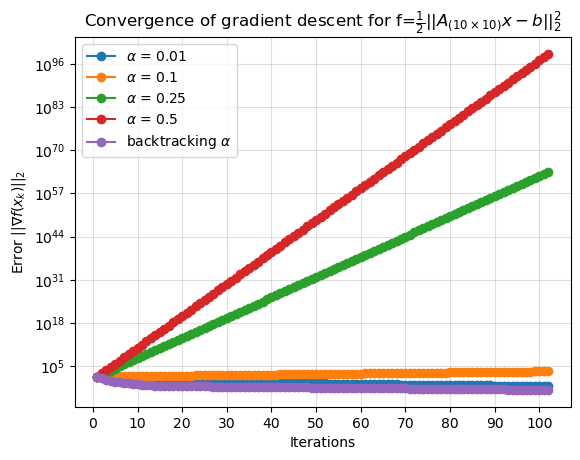

Stopped: k >= kmax (maximum number of iterations reached)


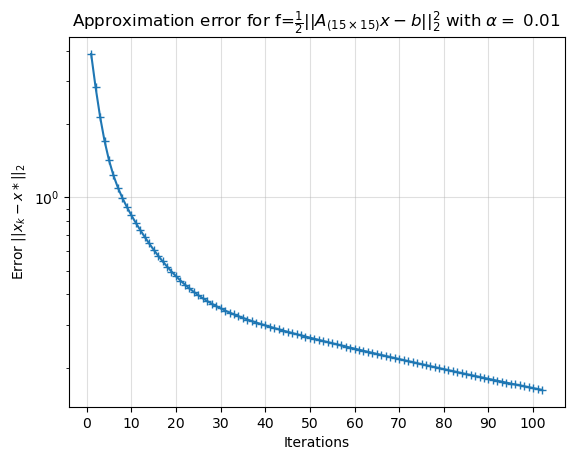

Stopped: k >= kmax (maximum number of iterations reached)


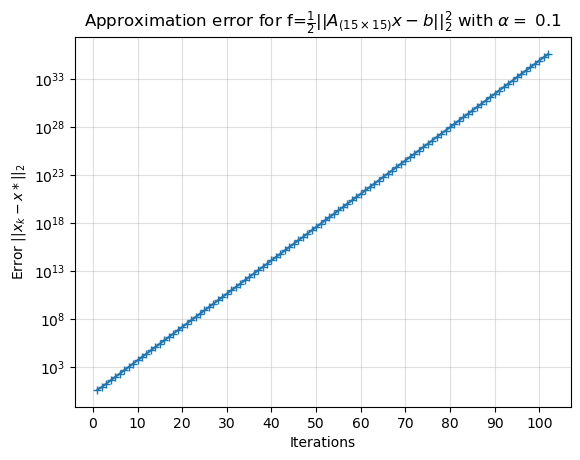

Stopped: k >= kmax (maximum number of iterations reached)


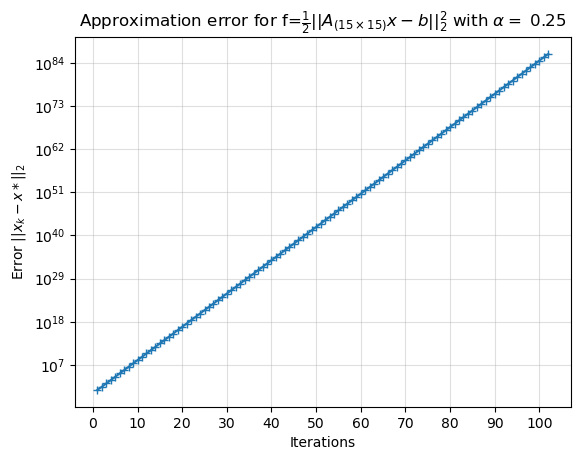

Stopped: k >= kmax (maximum number of iterations reached)


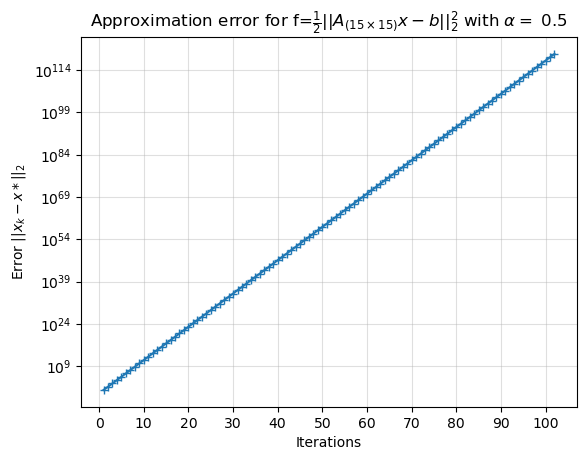

Stopped: k >= kmax (maximum number of iterations reached)


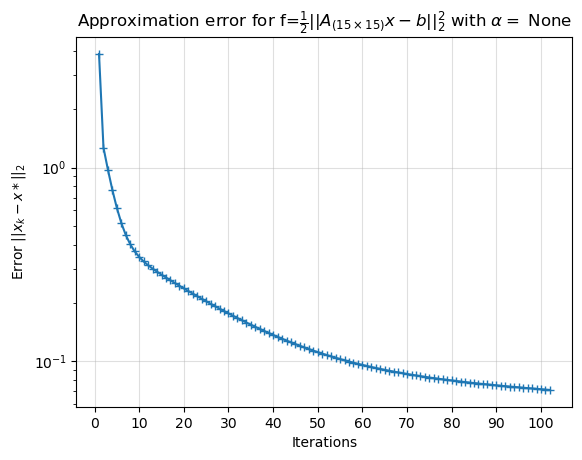

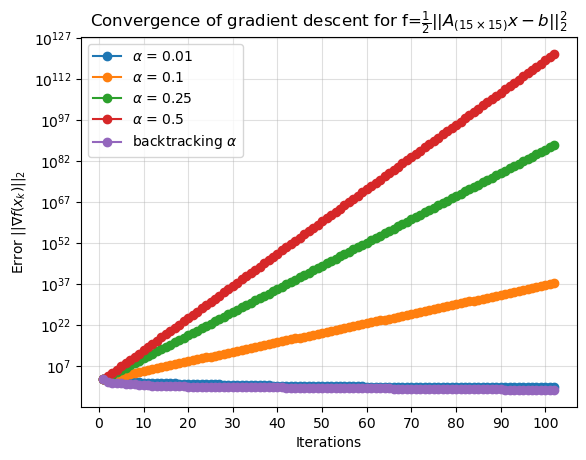

In [543]:
for n in [5, 10, 15]:
    effe3_x0 = np.zeros(n)
    effe3_xstar = np.ones(n)
    effe3_string = f"$\\frac{{1}}{{2}}||A_{{({n}\\times{n})}}x - b||^2_2$"
    test_gd(effe3, grad_effe3, effe3_x0, effe3_xstar, effe3_string)

As the size $n$ of the Vandermonde matrix increases, the problem becomes increasingly ill-conditioned. Consequentely, to mitigate potential numerical instability and ensure convergence, it becomes necessary to decrease the step size $\alpha$ as $n$ increases. The backtracking algorithm automatically addressses this issue by dynamically adjusting $\alpha$ during each iteration of gradient descent.

### Function 4 tests

Stopped: k >= kmax (maximum number of iterations reached)


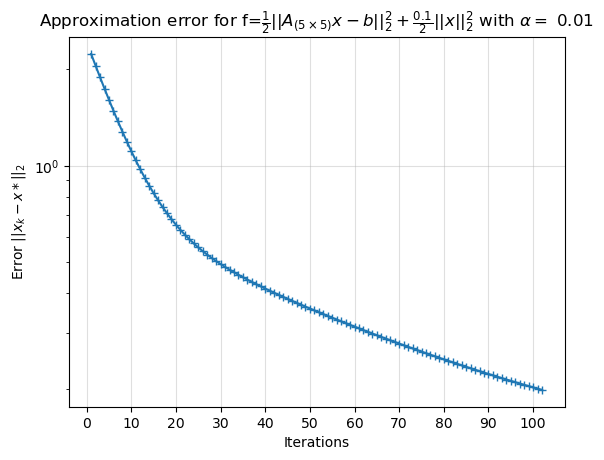

Stopped: k >= kmax (maximum number of iterations reached)


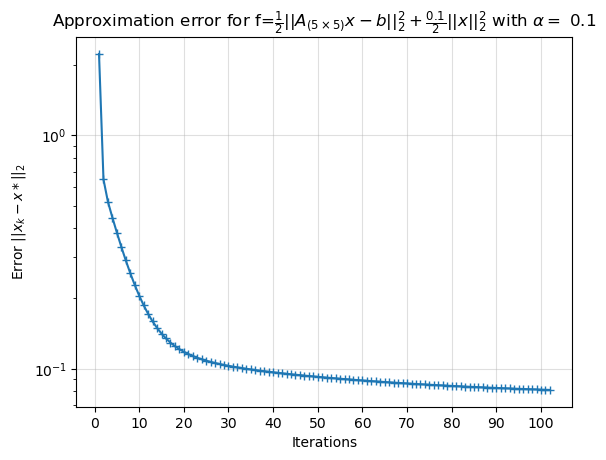

Stopped: k >= kmax (maximum number of iterations reached)


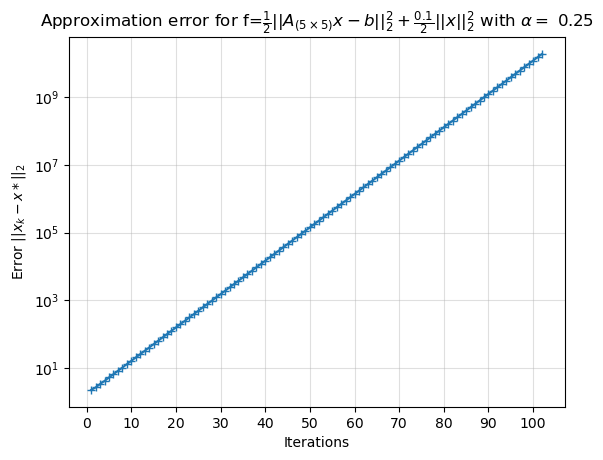

Stopped: k >= kmax (maximum number of iterations reached)


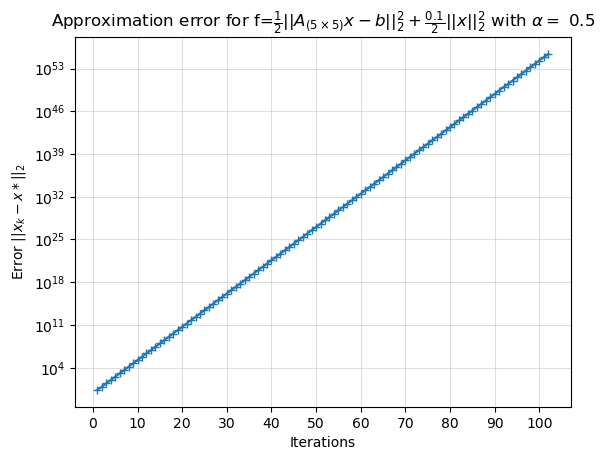

Stopped: k >= kmax (maximum number of iterations reached)


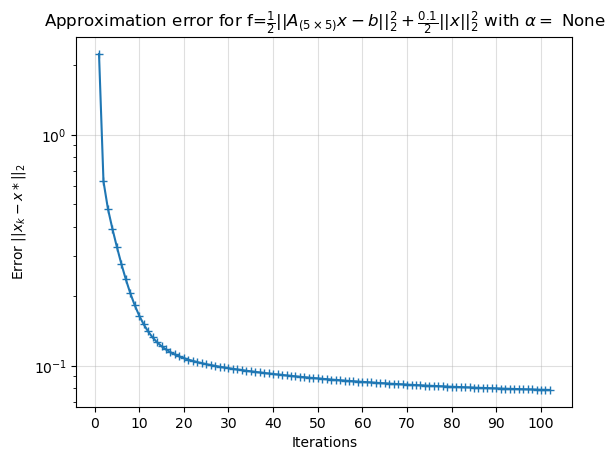

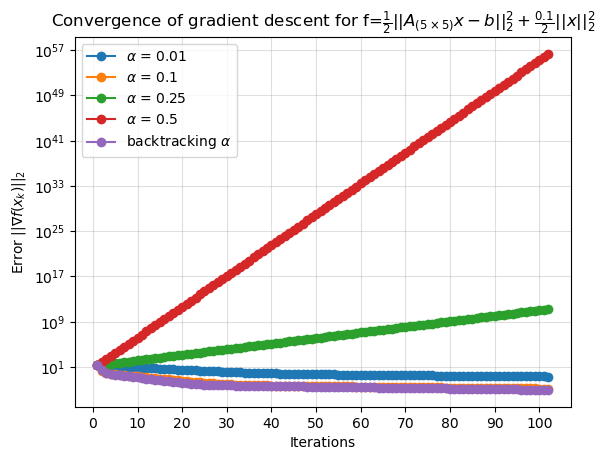

Stopped: k >= kmax (maximum number of iterations reached)


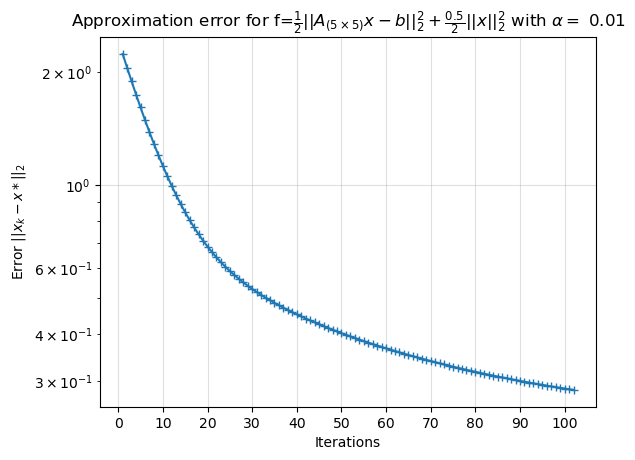

Stopped: k >= kmax (maximum number of iterations reached)


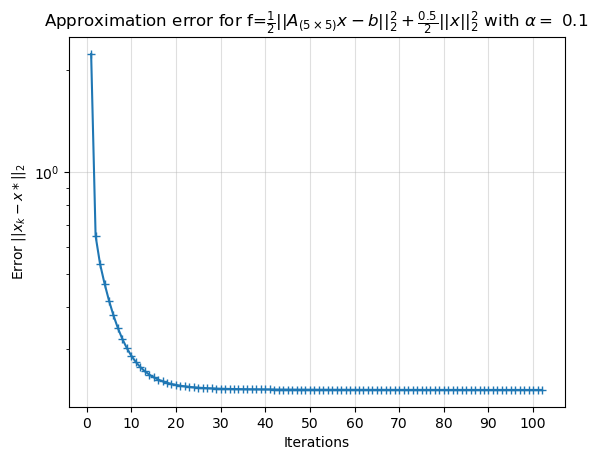

Stopped: k >= kmax (maximum number of iterations reached)


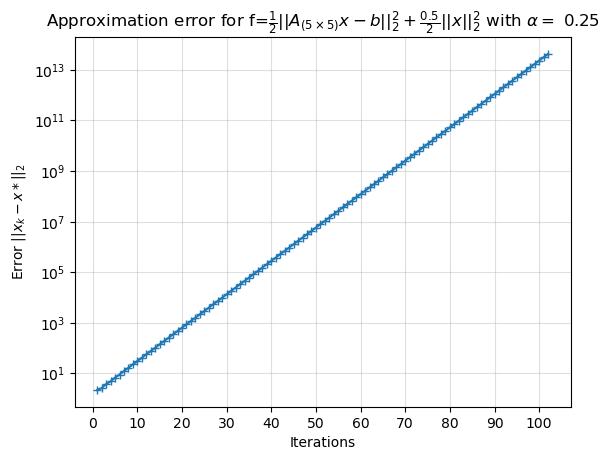

Stopped: k >= kmax (maximum number of iterations reached)


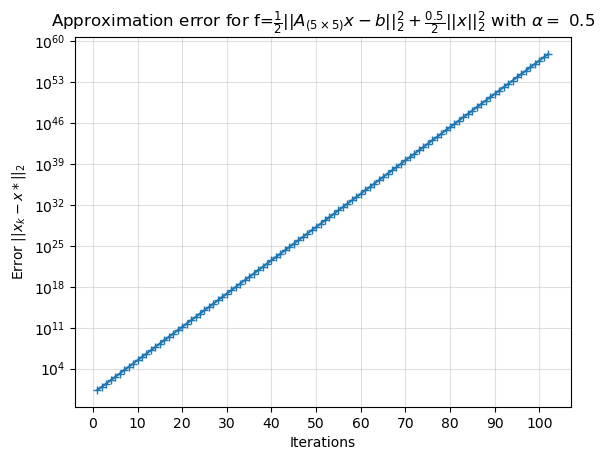

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 82


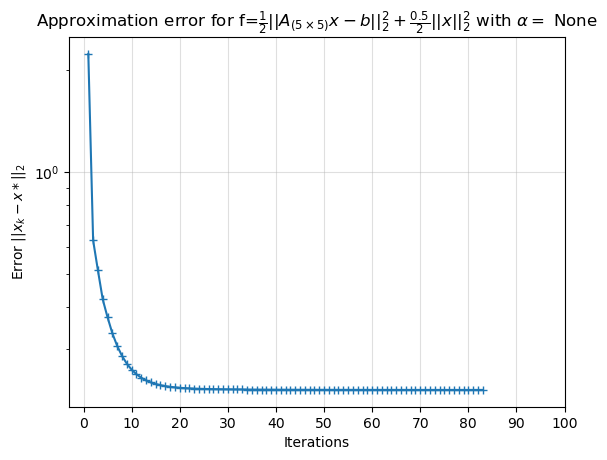

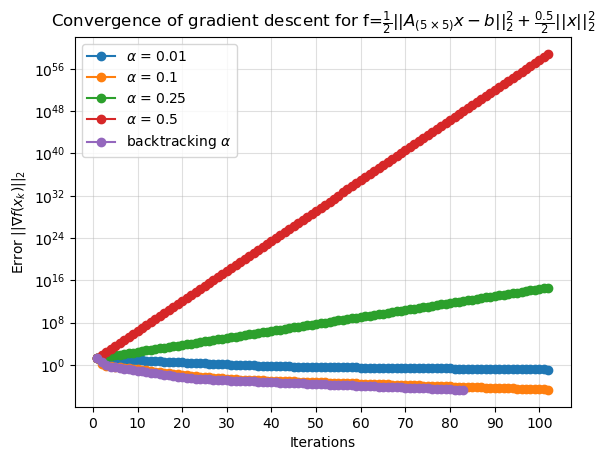

Stopped: k >= kmax (maximum number of iterations reached)


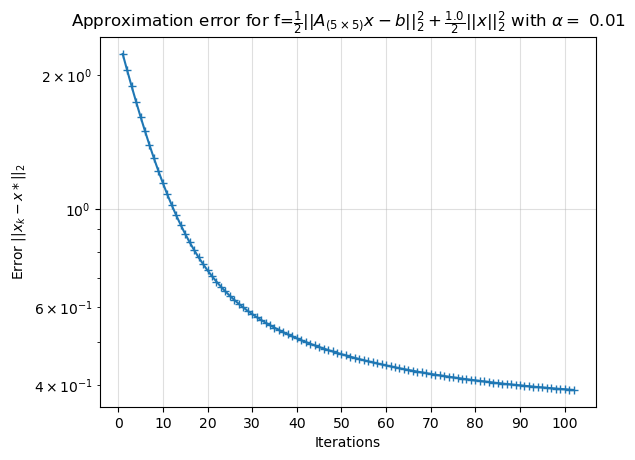

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 55


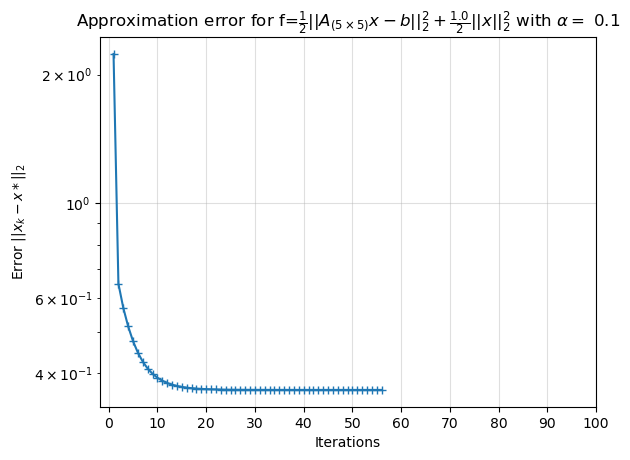

Stopped: k >= kmax (maximum number of iterations reached)


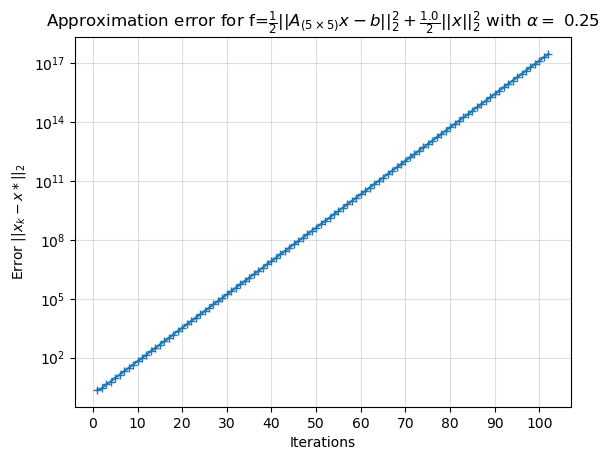

Stopped: k >= kmax (maximum number of iterations reached)


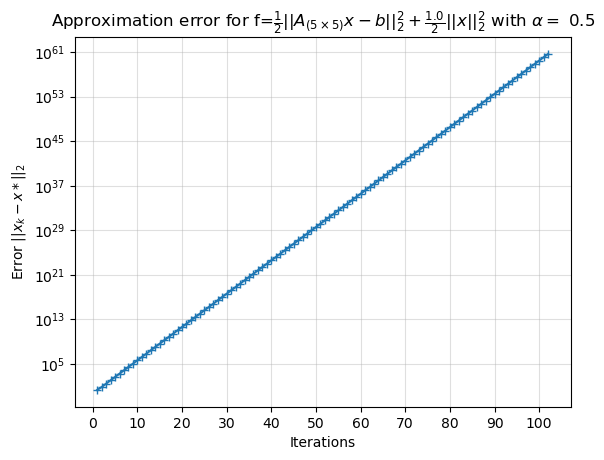

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 44


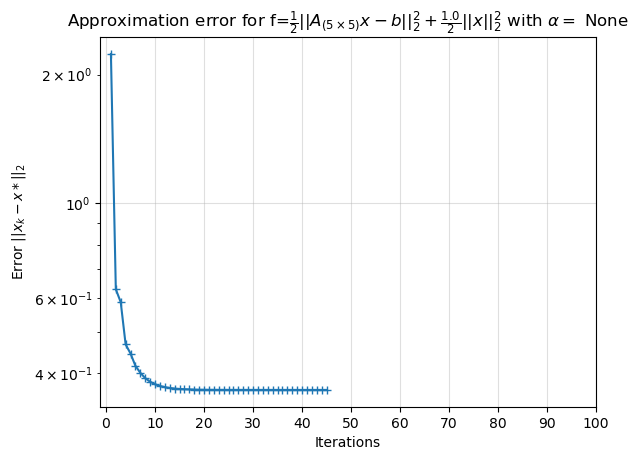

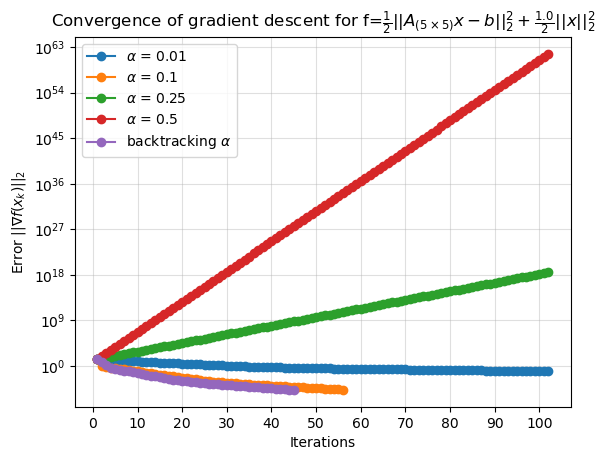

In [544]:
n = 5

for lmb in [.1, .5, 1.]:
    effe4, grad_effe4 = generate_effe4(lmb)
    effe4_x0 = np.zeros(n)
    effe4_xstar = np.ones(n)
    effe4_string = f"$\\frac{{1}}{{2}}||A_{{({n}\\times{n})}}x - b||^2_2+\\frac{{{lmb}}}{{2}}||x||_2^2$"
    test_gd(effe4, grad_effe4, effe4_x0, effe4_xstar, effe4_string)

By introducing $\ell_2$ regularization to the previous function, controlled by the hyperparameter $\lambda$, we penalize large function values during minimization. As $\lambda$ increases, the regularization term becomes higher, pushing the values to smaller magnitudes. By doing that we can reduce numerical instability and potentially converge faster. However, excessively high $\lambda$ values can overly constraint the function values, slowing down the convergence speed.

### Function 5 tests

Stopped: k >= kmax (maximum number of iterations reached)


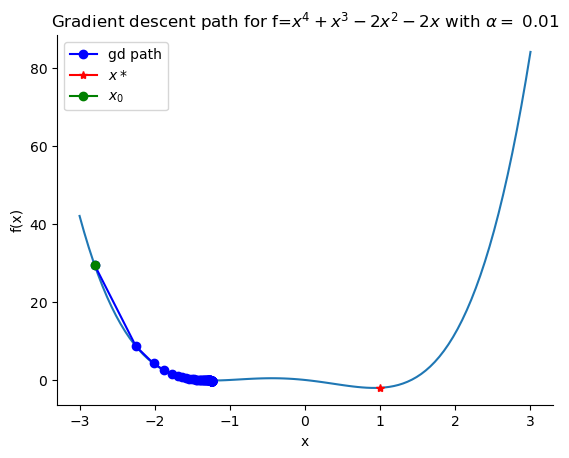

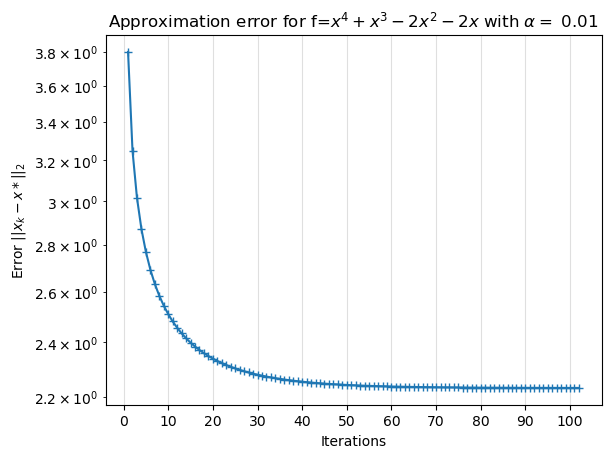

/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_62059/3524031235.py:42: RuntimeWarning: overflow encountered in scalar power
  return np.array([4 * x[0]**3 + 3 * x[0]**2 - 4 * x[0] -2])
/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_62059/3524031235.py:42: RuntimeWarning: invalid value encountered in scalar add
  return np.array([4 * x[0]**3 + 3 * x[0]**2 - 4 * x[0] -2])
/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_62059/3524031235.py:40: RuntimeWarning: overflow encountered in scalar power
  return x[0]**4 + x[0]**3 - 2 * x[0]**2 - 2 * x[0]
/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_62059/3524031235.py:40: RuntimeWarning: invalid value encountered in scalar add
  return x[0]**4 + x[0]**3 - 2 * x[0]**2 - 2 * x[0]


Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 8


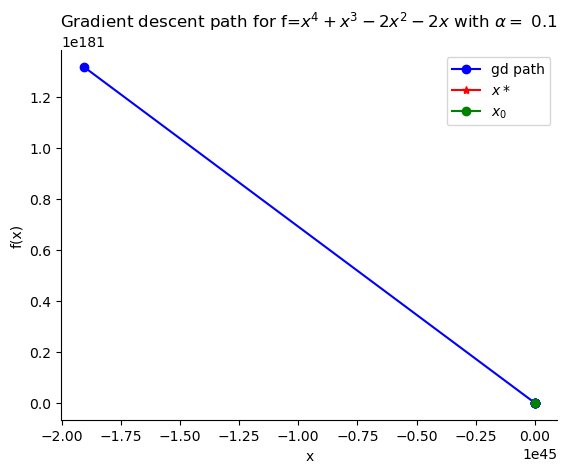

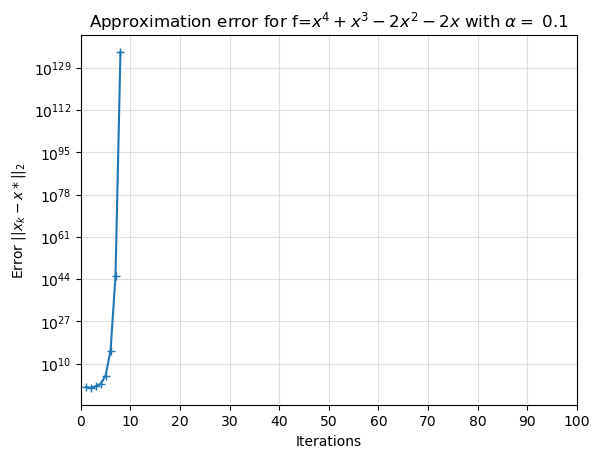

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 44


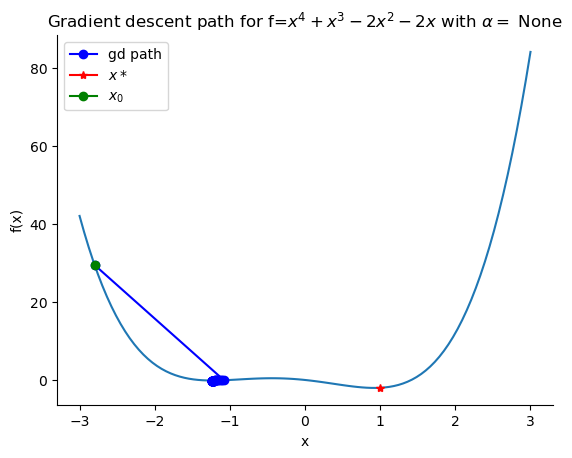

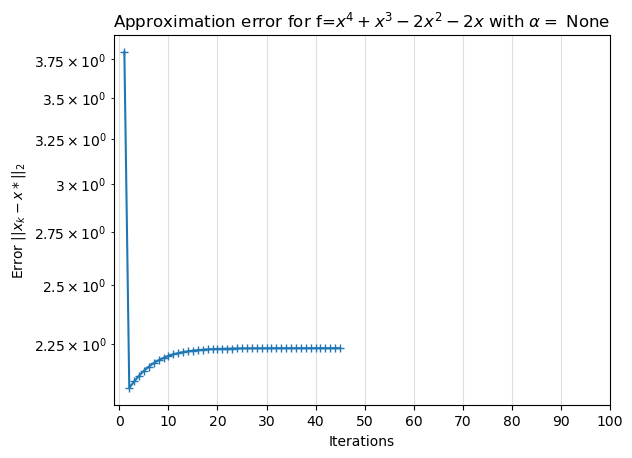

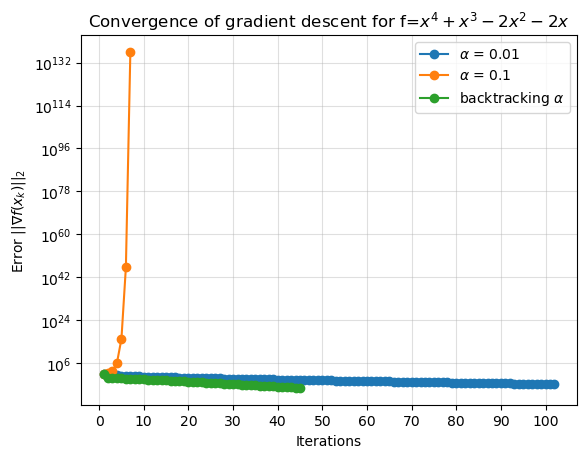

Stopped: k >= kmax (maximum number of iterations reached)


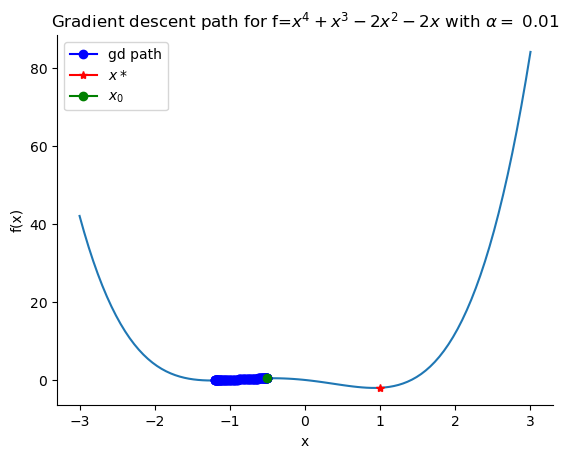

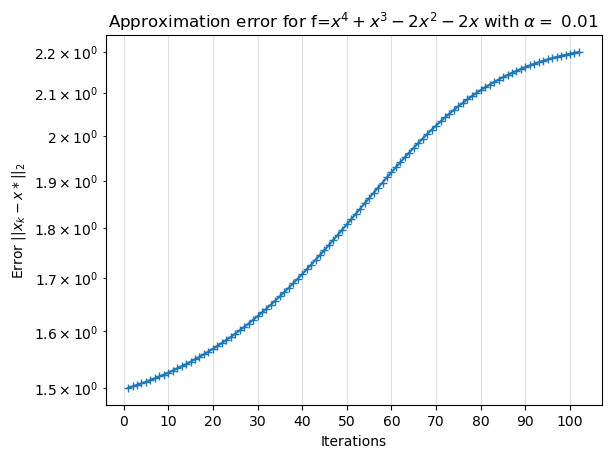

Stopped: ||x_k - x_18||_2 < tolx (tolx reached) at iteration 20


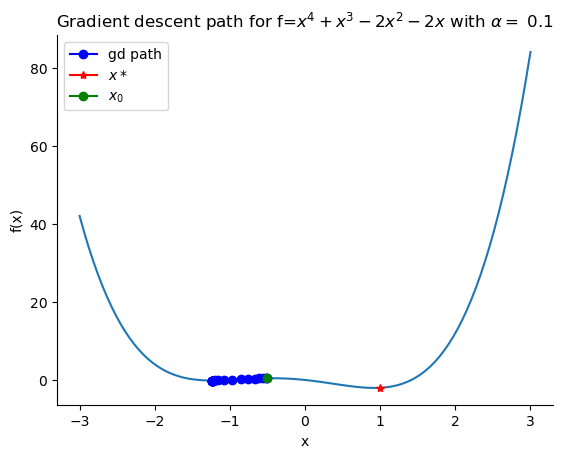

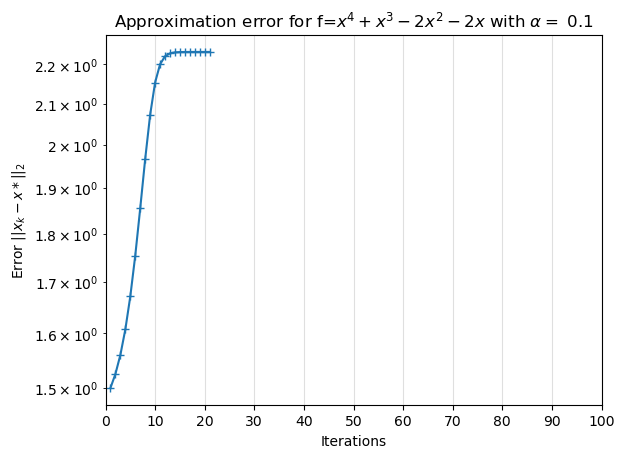

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 8


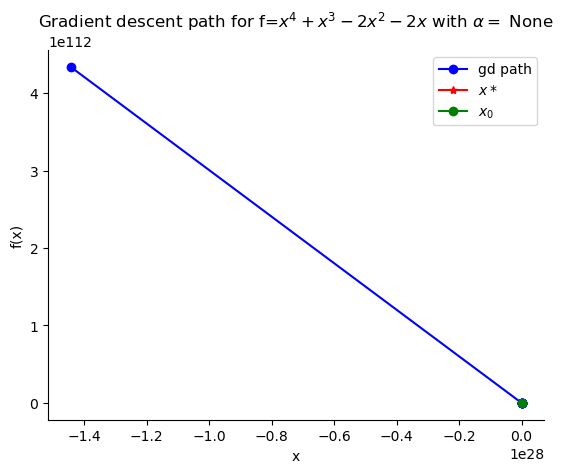

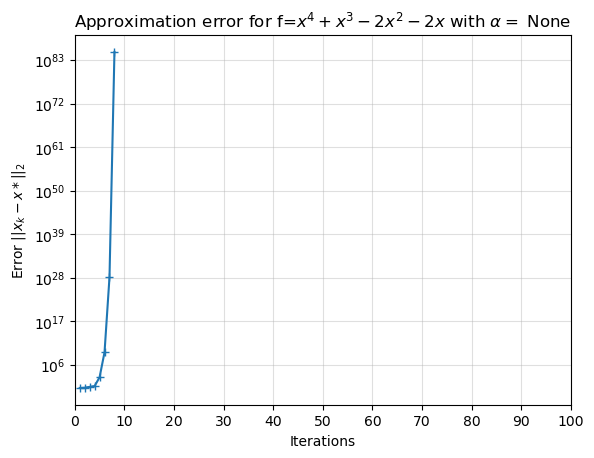

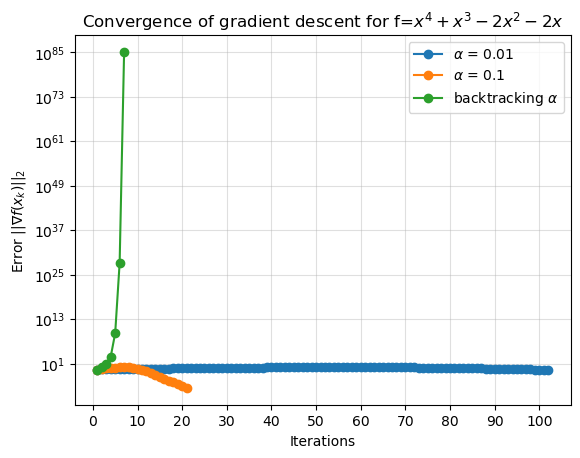

Stopped: k >= kmax (maximum number of iterations reached)


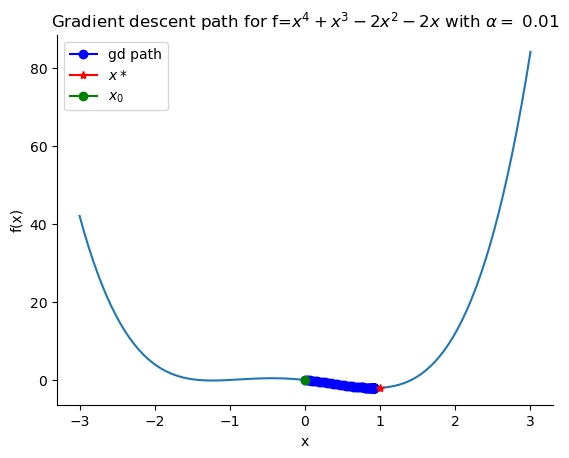

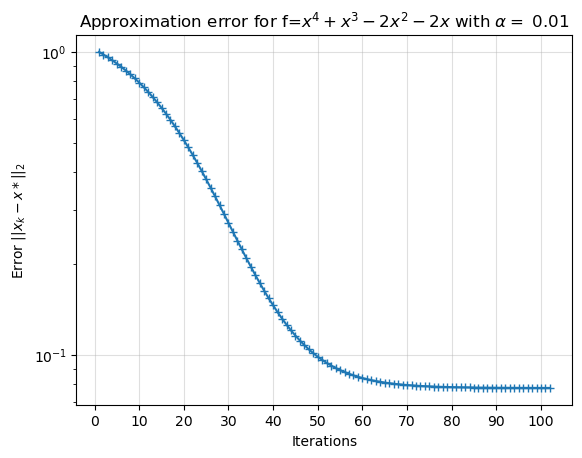

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 11


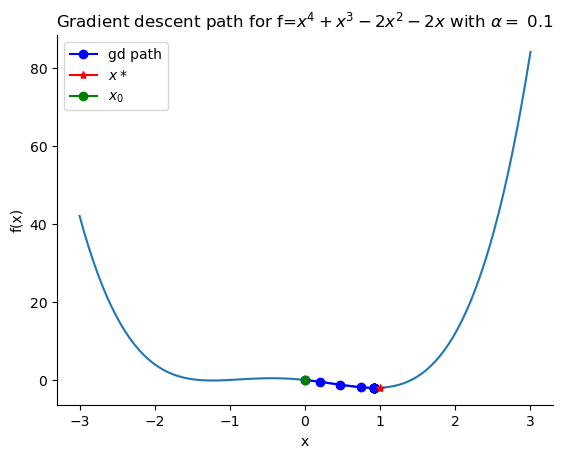

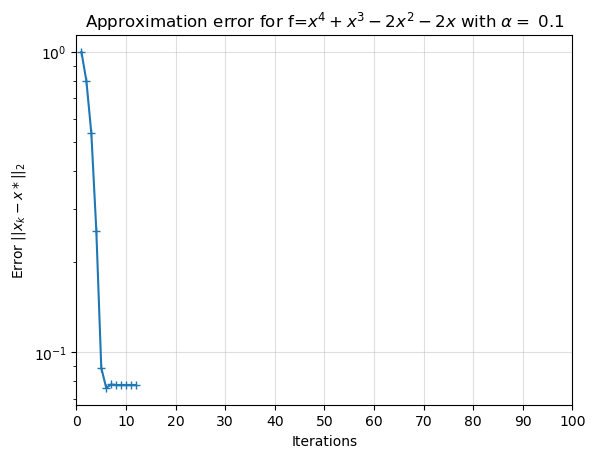

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 10


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_62059/3524031235.py:40: RuntimeWarning: invalid value encountered in scalar subtract
  return x[0]**4 + x[0]**3 - 2 * x[0]**2 - 2 * x[0]


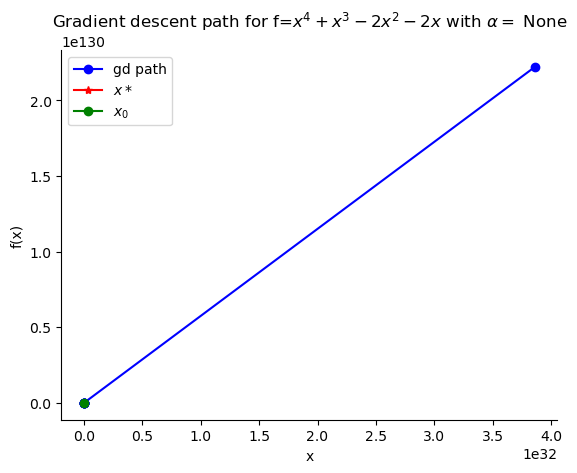

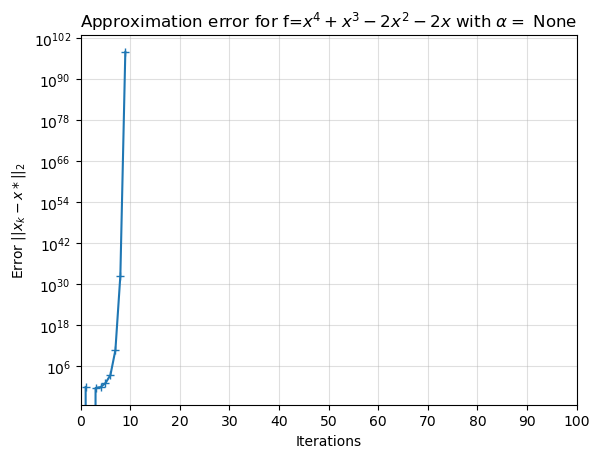

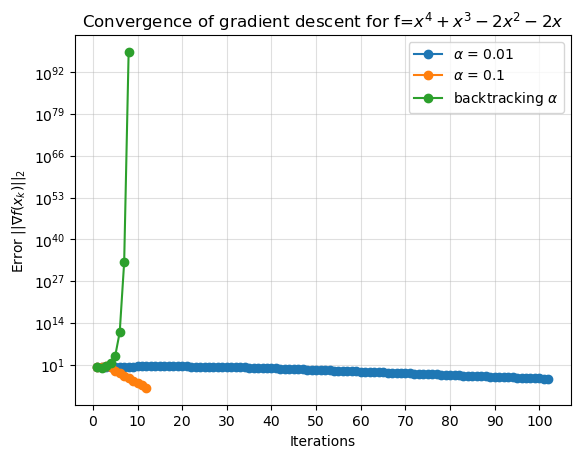

Stopped: ||x_k - x_86||_2 < tolx (tolx reached) at iteration 88


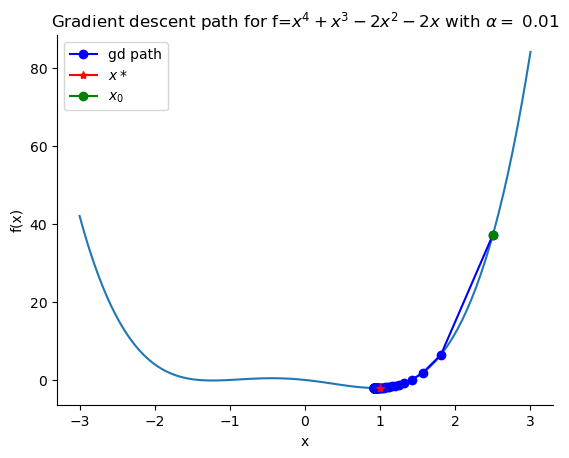

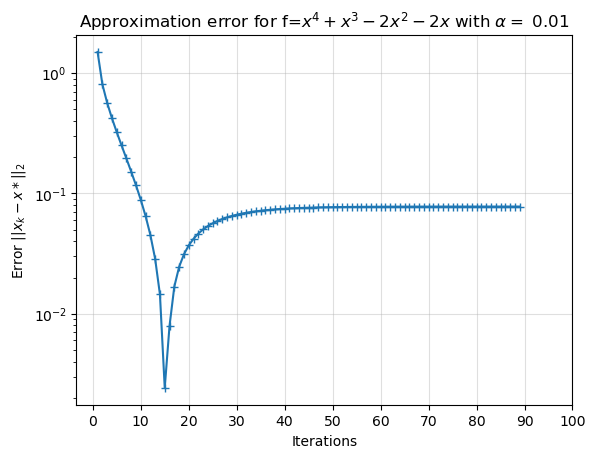

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 7


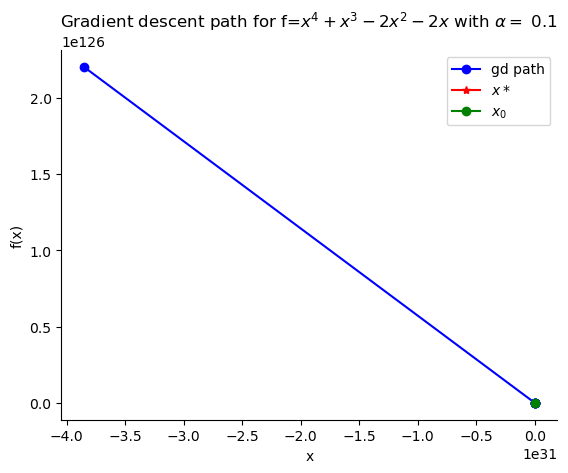

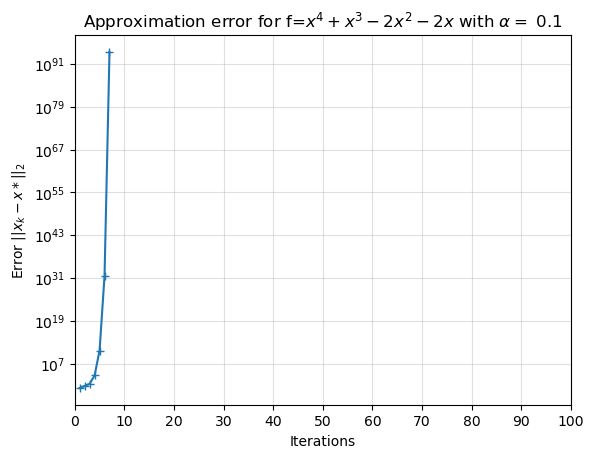

Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 30


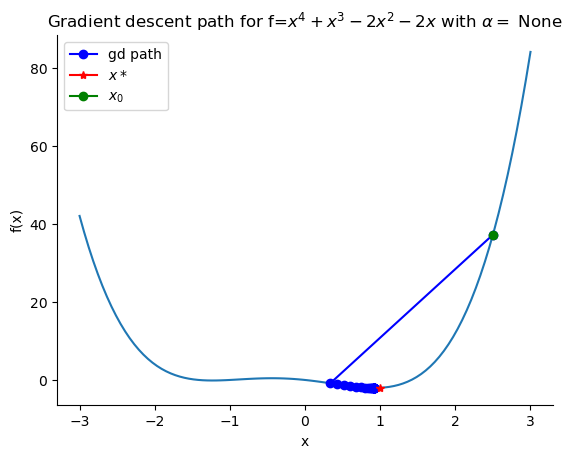

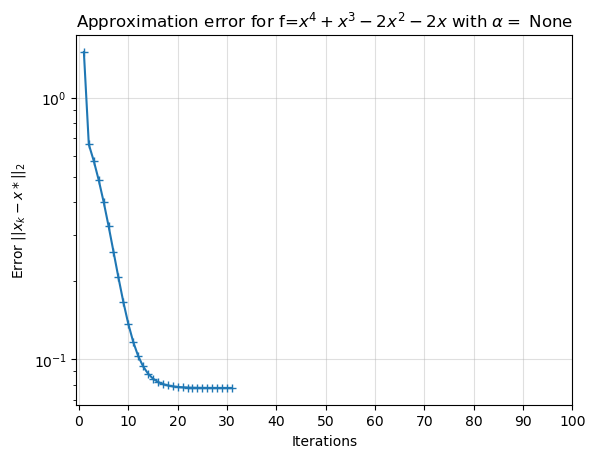

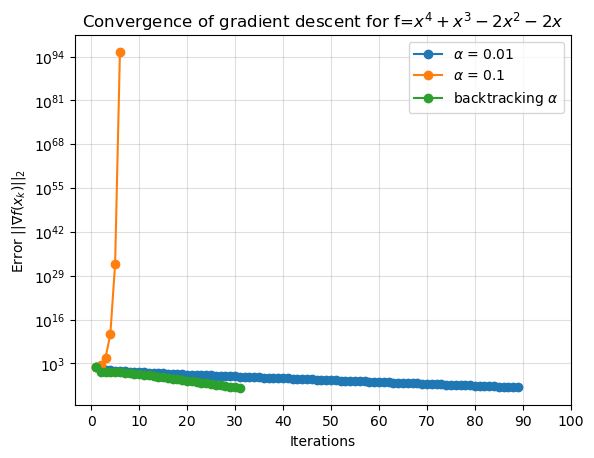

In [567]:
effe5_x1_range = (-3, 3)
effe5_string = "$x^4+x^3-2x^2-2x$"

starting_points = [-2.8, -0.5, 0, 2.5]

for effe5_x0 in starting_points:
    test_gd(effe5, grad_effe5, (effe5_x0,), (1,), effe5_string, a_list=[0.01, 0.1, None], x1_range=effe5_x1_range)

The initial point $x_0$ influences the minimum that is found. Since it isn't a convex function we need to pick the closest point to the stationary point correspondind to the global minimum. Moreover, in the steepest regions in this function, the descent direction could change too quickly and that increases the likelihood of divergence. A too high step size would likely diverge, while too small step size won't reach the solution

## Optimization via Stochastic Gradient Descent

* $X\in\mathbb{R}^{d\times N}$
* $\hat{X}\in\mathbb{R}^{k\times N}$ where $k=d+1$
* $w\in \mathbb{R}^{k\times 1}$
* $\hat{X}^Tw\in \mathbb{R}^{N\times 1}$

- [x] From the MNIST dataset, select two digits.
- [x] Obtain the training and test set from $(X, Y)$, selecting the $N_{train}$ you prefer.
- [x] Implement a logistic regression classifier following [https://www.evangelistadavide.com/teaching/logistic_regression2024/](https://www.evangelistadavide.com/teaching/logistic_regression2024/).
- [x] Test the logistic regression classifier for different digits and different training set dimensions.
- [x] Compare $w^*$ when computed with Gradient Descent and Stochastic Gradient Descent, for different digits and different training set dimensions.
- [x] Comment on the obtained results (in terms of the accuracy of the learned classifier).

In [531]:
import numpy as np
from numpy.linalg import norm, inv
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def add_ones_row(X):
    N = X.shape[1]
    ones_row = np.ones((1, N))
    Xhat = np.concatenate((ones_row, X), axis=0)
    return Xhat
    
def binarize_labels(Y, digit2):
    return (Y == digit2).astype(np.int32)
    
def load_data(digit1, digit2, filepath="./MNIST.csv"):
    data = pd.read_csv(filepath).values

    X = data[:, 1:].T
    Y = data[:, 0]

    mask = (Y == digit1) | (Y == digit2)

    X_filtered = X[:, mask]
    Y_filtered = Y[mask]

    return X_filtered, binarize_labels(Y_filtered[:, np.newaxis], digit2)

def train_test_split(X, Y, train_size, seed=42):
    N = X.shape[1]
    train_size = int(train_size * N / 100)

    np.random.seed(seed)
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:train_size]
    test_idx = idx[train_size:]

    Xtrain, Xtest = X[:, train_idx], X[:, test_idx]
    Ytrain, Ytest = Y[train_idx], Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)
    
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
def f(w, xhat):
    return sigmoid(np.dot(xhat.T, w))

def l(w, X, Y):
    N = X.shape[1]
    Y_pred = f(w, X)
    return (1/(2 * N)) * norm(Y_pred - Y, 2) ** 2

def grad_l(w, X, Y):
    N = X.shape[1]
    Y_pred = f(w, X)
    return np.dot(X, (Y_pred * (1 - Y_pred) * (Y_pred - Y))) / N

def predict(w, X, threshold=0.5):
    probas = f(w, X)
    return (probas >= threshold).astype(int)

def accuracy(Y_pred, Y):
    return np.mean(Y_pred == Y)

def sgd(l, grad_l, w0, data, batch_size, n_epochs, a=0.1):
    """
    Parameters
    ----------
    l: the function l(w; D) we want to optimize. It is supposed to be a Python function, not an array.
    grad_l: the gradient of l(w; D). It is supposed to be a Python function, not an array.
    w0: an n-dimensional array which represents the initial iterate. By default, it should be randomly sampled.
    data: a tuple (x, y) that contains the two arrays x and y, where x is the input data, y is the output data.
    batch_size: an integer. The dimension of each batch. Should be a divisor of the number of data.
    n_epochs: an integer. The number of epochs you want to repeat the iterations.
    
    Returns
    ----------
    w: an array that contains the value of w_k FOR EACH iterate w_k (not only the latter).
    f_val: an array that contains the value of l(w_k; D) FOR EACH iterate w_k ONLY after each epoch.
    grads: an array that contains the value of grad_l(w_k; D) FOR EACH iterate w_k ONLY after each epoch.
    err: an array that contains the value of ||grad_l(w_k; D)||_2 FOR EACH iterate w_k ONLY after each epoch.
    """
    X, Y = data
    N = X.shape[1]
    w = [w0]
    f_val = []
    grads = []
    err = []
    
    for epoch in range(n_epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)

        for i in range(0, N, batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X[:, batch_indices]
            Y_batch = Y[batch_indices]

            grad = grad_l(w[-1], X_batch, Y_batch)
            w.append(w[-1] - a * grad) 

        f_val.append(l(w[-1], X, Y))
        grad_full = grad_l(w[-1], X, Y)
        grads.append(grad_full)
        err.append(norm(grad_full, 2))
 
    return w, f_val, grads, err

def gd(l, grad_l, w0, data, a = 0.1, kmax = 1000, tolf = 1e-6, tolx = 1e-6):
    X, Y = data
    k = 0
    w = [w0]
    err = [norm(grad_l(w[0], X, Y), 2)]
    
    condition = True
    while condition:
        grad = grad_l(w[-1], X, Y)
        w.append(w[-1] - a * grad) 
        err.append(norm(grad, 2))

        condition1 = err[-1] >= tolf * err[0]
        condition2 = norm(w[-1] - w[-2], 2) >= tolx 
        condition3 = k < kmax
        condition = condition1 and condition2 and condition3

        if not condition1:
            print(f"Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration {k+1}")
        elif not condition2:
            print(f"Stopped: ||x_k - x_k-1||_2 < tolx (tolx reached) at iteration {k+1}")
        elif not condition3:
            print(f"Stopped: k >= kmax (maximum number of iterations reached)")

        k += 1
        
    return w, err 

In [532]:
X, Y = load_data(3, 8)
train_data, test_data = train_test_split(add_ones_row(X), Y, 80)
w0 = np.random.normal(size=(X.shape[0] + 1, 1))
batch_size = 64

# Sanity check
print(f"Xhat shape: {train_data[0].shape}") # k,N
print(f"Y shape: {train_data[1].shape}") # N,1
print(f"w0 shape: {w0.shape}") # k,1
print(f"fw(Xhat) shape: {f(w0, train_data[0]).shape}") # N,1
print(f"fw(Xhat) - Y shape: {(f(w0, train_data[0]) - train_data[1]).shape}") # N,1
print(f"grad_l: {grad_l(w0, train_data[0][:, :batch_size], train_data[1][:batch_size]).shape}")# k,1
w_sgd = sgd(l, grad_l, w0, train_data, batch_size, n_epochs)[0]
wstar = w_sgd[-1]
print(f"Acc: {accuracy(predict(wstar, test_data[0]), test_data[1])}")

Xhat shape: (785, 6731)
Y shape: (6731, 1)
w0 shape: (785, 1)
fw(Xhat) shape: (6731, 1)
fw(Xhat) - Y shape: (6731, 1)
grad_l: (785, 1)
Acc: 0.8734402852049911


In [533]:
batch_size = 64
n_epochs = 20

for digit_pair in [(3,8), (1,7), (2,3), (3,7)]:
    print(f"{'='*100}")
    print(f"Evaluating digit pair: {digit_pair[0]} and {digit_pair[1]}")
    print(f"{'-'*100}")
    for train_size in [20, 60, 80]:
        X, Y = load_data(*digit_pair)
        train_data, (Xtest, Ytest) = train_test_split(add_ones_row(X), Y, train_size)
        w0 = np.random.normal(size=(X.shape[0] + 1, 1))

        w_gd = gd(l, grad_l, w0, train_data)[0]
        w_sgd = sgd(l, grad_l, w0, train_data, batch_size, n_epochs)[0]

        acc_gd = accuracy(predict(w_gd[-1], Xtest), Ytest)
        acc_sgd = accuracy(predict(w_sgd[-1], Xtest), Ytest)
        
        print(f"Accuracy with training set size {train_data[0].shape[1]} using GRADIENT DESCENT: {acc_gd:.4f}")
        print(f"Accuracy with training set size {train_data[0].shape[1]} using STOCHASTIC GRADIENT DESCENT: {acc_sgd:.4f}")
    print(f"{'='*100}\n")

Evaluating digit pair: 3 and 8
----------------------------------------------------------------------------------------------------
Stopped: ||grad_f(x_k)||_2 < tolf * ||grad_f(x_0)||_2 (tolf reached) at iteration 24
Accuracy with training set size 1682 using GRADIENT DESCENT: 0.5117
Accuracy with training set size 1682 using STOCHASTIC GRADIENT DESCENT: 0.5101
Stopped: k >= kmax (maximum number of iterations reached)
Accuracy with training set size 5048 using GRADIENT DESCENT: 0.5163
Accuracy with training set size 5048 using STOCHASTIC GRADIENT DESCENT: 0.8301
Stopped: ||x_k - x_k-1||_2 < tolx (tolx reached) at iteration 868
Accuracy with training set size 6731 using GRADIENT DESCENT: 0.5342
Accuracy with training set size 6731 using STOCHASTIC GRADIENT DESCENT: 0.8734

Evaluating digit pair: 1 and 7
----------------------------------------------------------------------------------------------------
Stopped: ||x_k - x_k-1||_2 < tolx (tolx reached) at iteration 693
Accuracy with train